In [1]:
import math
import numpy as np
import pandas as pd
from ces_direct_energy_utils import *

In [2]:
## scenario switch
case=3 # 2 means no trade in goods; 3 means trade in both energy and goods
logit = 0 # 1 means logit estimations of supply elasticity; 0 means fixed elasticities

## parameter values
theta = 4             # scopevec for comparative advantage
sigma = 1      # elasticity of demand for each individual manufactured good j at Home
sigmastar = 1  # elasticity of demand for each individual manufactured good j at Foreign
sigmaE = 1
sigmaEstar = 1

# beta gamma not used in the code unless logit indicated
beta=1.892412
gamma=0.807998928

In [3]:
# carbon content per unit of energy
h1 = 1
h2 = 0

# elasticity of supply of renewables
epsilonSstar1 = 0.5
epsilonS1 = 0.5
epsilonSstar2 = 0.5
epsilonS2 = 0.5

# make sure that epsilonSvec and epsilonSstarvec have equal length
# if a country does not have that energy source, set proportion to 0
epsilonSvec = [(epsilonS1, 1, 0.867), (epsilonS2, h2, 0.133)]
epsilonSstarvec = [(epsilonSstar1, 1,0.867), (epsilonSstar2, h2, 0.133)]

# baseline, no renewable energy
epsilonSvec = [(epsilonS1, h1, 1), (epsilonS2, h2, 0)]
epsilonSstarvec = [(epsilonSstar1, h1, 1), (epsilonSstar2, h2, 0)]
assert(sum(k for i,j,k in epsilonSvec) == 1)
assert(sum(k for i,j,k in epsilonSstarvec) == 1)

In [4]:
## import BAU values (seven regional scenarios in the order of US, EU, OECD, World, China, OECD plus China)
if case==2:
    df = pd.read_csv("../../raw_data/BaselineCarbon_2015_noTradeinGoods.csv",index_col=['region_scenario','regionbase'],header='infer')
elif case==3:
    # comment out if running simulation with no renewables
    df = pd.read_csv("../../raw_data/BaselineCarbonRenewable_2015.csv", index_col=['regionbase'],header='infer')
    df = pd.read_csv("../../raw_data/BaselineCarbon_direct_cons.csv", index_col=['regionbase'],header='infer')
df['jxbar']=df['CeFH']/(df['CeFH'] + df['CeFF'])
df['jmbar']=df['CeHH']/(df['CeHH'] + df['CeHF'])

## choose which regional scenario to run (runs all if not executed)
#df=df.drop([2,3,4,5,6,7])  
df = df[df['region_scenario'] == 3]
#df = df[df['region_scenario'] != 4]
df

,region_scenario,Qe,Qestar,Qeworld,CeHH_old,CeHF,CeFH,CeFF_old,Ce,Cestar,...,Gestar,Ceworld,Geworld,Unnamed: 15,Cec,Cecstar,CeHH,CeFF,jxbar,jmbar
regionbase,,,,,,,,,,,,,,,,,,,,,
OECD37 as Home,3,8.62549,23.6505,32.27599,11.29367,2.48754,0.91057,17.58421,13.78121,18.49478,...,14.795824,32.27599,32.27599,NaN,2.756242,3.698956,8.537428,13.885254,0.061542,0.774372


In [5]:
#tax_scenario= pd.DataFrame({'tax_sce': ['Unilateral','global','purete','puretc','puretp','EC_hybrid','EP_hybrid','PC_hybrid','EPC_hybrid'], 'Base':[0,1,1,1,1,1,1,1,1]},index=[1,2, 3, 4, 5, 6, 7, 8,9])
#tax_scenario= pd.DataFrame({'tax_sce': ['Unilateral','purete','puretc','puretp','EC_hybrid','EP_hybrid','PC_hybrid','EPC_hybrid'], 'Base':[0,1,1,1,1,1,1,1]},index=[1,2, 3, 4, 5, 6, 7, 8])
#tax_scenario= pd.DataFrame({'tax_sce': ['PC_hybrid'], 'Base':[1]},index=[1])
tax_scenario= pd.DataFrame({'tax_sce': ['Unilateral'], 'Base':[0]},index=[1])

In [6]:
def iterate_tax(tax_scenario,df,theta, sigma, sigmastar, sigmaC, sigmaCstar, epsilonSvec, epsilonSstarvec, beta, gamma, logit):
    paralist = (theta, sigma, sigmastar, sigmaE, sigmaEstar, epsilonSvec, epsilonSstarvec, beta, gamma, logit)
    varphilist = np.arange(0,3,0.1)
    #varphilist = np.arange (0,1,0.2)
    #varphilist = [0]
    output=[]
    prevtb = []
    for varphi in varphilist:    
        tax_df=df.apply(iterate_region, axis=1, raw=False, args=(prevtb, varphi, tax_scenario, paralist))
        prevtb = tax_df[['region_scenario','tb', 'pe', 'te', 'prop']]
        output.append(tax_df)
        print(varphi)
        
    output = pd.concat(output, axis=0, join='outer',  ignore_index=False, keys=None, levels=None, names=None, verify_integrity=False,copy=True)
    output.reset_index(level=0, inplace=True)
    output = output.sort_values(by=['region_scenario','varphi'])
    
    # if extraction tax too large home stops extracting
    if tax_scenario['tax_sce']=='purete' or tax_scenario['tax_sce']=='EP_hybrid' or tax_scenario['tax_sce'] == 'Unilateral':
        output.te[output.Qe_prime==0]=output.pe+output.tb
    print(tax_scenario['tax_sce'])
    return output

In [7]:
def iterate_region(df, prevtb, varphi, tax_scenario, paralist):
    # initial guess if previous value isn't available
    pe = 1
    te = 0.5
    tb_mat = [0,0.5]
    
    # use previous vector of solution if available
    if (type(prevtb) != list):
        curr_region = prevtb[prevtb['region_scenario'] == df['region_scenario']]
        vals = curr_region.values
        tb_mat = [vals[0][1], vals[0][4]]
        pe = vals[0][2]
        te = vals[0][3]
    tax_temp = tax_eq(pe, te, tb_mat, df, tax_scenario, varphi, paralist)
    tax_temp.opt_tax()
    ret = tax_temp.retrieve()
    return ret

In [8]:
temp_df = tax_scenario.apply(iterate_tax, axis=1, args=(df,theta, sigma, sigmastar, sigmaE, sigmaEstar, epsilonSvec, epsilonSstarvec, beta, gamma, logit))

/Users/alexdong/Desktop/Optimal-Unilateral-Carbon-Policy/simulation_results/codes/direct_energy_consumption/ces_direct_energy_utils.py:628: RuntimeWarning: invalid value encountered in double_scalars
  leakage1 = -(Qestar_prime - df['Qestar']) / (Qeworld_prime - df['Qeworld'])
/Users/alexdong/Desktop/Optimal-Unilateral-Carbon-Policy/simulation_results/codes/direct_energy_consumption/ces_direct_energy_utils.py:629: RuntimeWarning: divide by zero encountered in double_scalars
  leakage2 = -(Gestar_prime - df['Gestar']) / (Qeworld_prime - df['Qeworld'])
/Users/alexdong/Desktop/Optimal-Unilateral-Carbon-Policy/simulation_results/codes/direct_energy_consumption/ces_direct_energy_utils.py:630: RuntimeWarning: invalid value encountered in double_scalars
  leakage3 = -(Cestar_prime - df['Cestar']) / (Qeworld_prime - df['Qeworld'])
/Users/alexdong/Desktop/Optimal-Unilateral-Carbon-Policy/simulation_results/codes/direct_energy_consumption/ces_direct_energy_utils.py:628: RuntimeWarning: invalid v

0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9
1.0
1.1
1.2000000000000002
1.3
1.4000000000000001
1.5
1.6
1.7000000000000002
1.8
1.9000000000000001
2.0
2.1
2.2
2.3000000000000003
2.4000000000000004
2.5
2.6
2.7
2.8000000000000003
2.9000000000000004
Unilateral


In [9]:
output_list=[]
for i in range(1,len(tax_scenario)+1):
    output_list.append(temp_df.loc[i])
Outcomes = pd.concat(output_list, axis=0, join='outer', ignore_index=False, keys=tax_scenario['tax_sce'], levels=None, verify_integrity=False,copy=True)
Outcomes.reset_index(level=0, inplace=True)
Outcomes

,tax_sce,regionbase,varphi,pe,tb,prop,te,jxbar_prime,jmbar_prime,j0_prime,...,delta_Vg,delta_Vgstar,welfare,welfare_noexternality,Qe1_prime,Qe1star_prime,Qe2_prime,Qe2star_prime,region_scenario,conv
0,Unilateral,OECD37 as Home,0.0,1.000000,0.000000,0.500000,0.000000,0.061542,0.774372,0.061542,...,-0.000000,-0.000000,-1.546764e-14,-1.546764e-14,8.625490,23.650500,0.0,0.0,3.0,1.0
1,Unilateral,OECD37 as Home,0.1,0.993667,0.039978,0.682820,0.100000,0.061565,0.774372,0.060190,...,-0.456042,0.073104,-6.339095e-02,-1.032381e-01,8.334407,23.575488,0.0,0.0,3.0,1.0
2,Unilateral,OECD37 as Home,0.2,0.988370,0.079571,0.190868,0.200000,0.061632,0.774372,0.058913,...,-0.905871,0.130121,-8.934193e-02,-2.477375e-01,8.035795,23.512568,0.0,0.0,3.0,1.0
3,Unilateral,OECD37 as Home,0.3,0.984048,0.118885,0.126718,0.300000,0.061739,0.774372,0.057707,...,-1.350176,0.171685,-7.829374e-02,-4.328717e-01,7.728998,23.461100,0.0,0.0,3.0,1.0
4,Unilateral,OECD37 as Home,0.4,0.980651,0.158020,0.095670,0.400000,0.061884,0.774372,0.056564,...,-1.789660,0.198275,-3.058253e-02,-6.584576e-01,7.413264,23.420579,0.0,0.0,3.0,1.0
5,Unilateral,OECD37 as Home,0.5,0.978145,0.197075,0.079920,0.500000,0.062062,0.774372,0.055481,...,-2.225049,0.210218,5.355598e-02,-9.247546e-01,7.087717,23.390632,0.0,0.0,3.0,1.0
6,Unilateral,OECD37 as Home,0.6,0.976505,0.236143,0.064918,0.600000,0.062273,0.774372,0.054451,...,-2.657104,0.207676,1.739730e-01,-1.232493e+00,6.751329,23.371016,0.0,0.0,3.0,1.0
7,Unilateral,OECD37 as Home,0.7,0.975720,0.275318,0.053338,0.700000,0.062513,0.774372,0.053472,...,-3.086637,0.190637,3.306226e-01,-1.582901e+00,6.402873,23.361624,0.0,0.0,3.0,1.0
8,Unilateral,OECD37 as Home,0.8,0.975793,0.314699,0.047319,0.800000,0.062781,0.774372,0.052539,...,-3.514535,0.158890,5.235423e-01,-1.977792e+00,6.040874,23.362497,0.0,0.0,3.0,1.0
9,Unilateral,OECD37 as Home,0.9,0.976742,0.354385,0.044776,0.900000,0.063076,0.774372,0.051649,...,-3.941787,0.111987,7.528558e-01,-2.419678e+00,5.663521,23.373850,0.0,0.0,3.0,1.0


In [10]:
Outcomes[['pe','tb', 'Cec_prime', 'Cecstar_prime', 'Cey_prime', 'Cex_prime', 'Cem_prime', 'Ceystar_prime', 'Vgx_prime', 'Vgm_prime']]

,pe,tb,Cec_prime,Cecstar_prime,Cey_prime,Cex_prime,Cem_prime,Ceystar_prime,Vgx_prime,Vgm_prime
0,1.000000,0.000000,2.756242,3.698956,8.537428,0.910570,2.487540,13.885254,6.070467,16.5836
1,0.993667,0.039978,2.666526,3.722532,8.259535,0.881322,2.406571,13.973409,6.072748,16.5836
2,0.988370,0.079571,2.580894,3.742482,7.994289,0.854116,2.329286,14.047296,6.079341,16.5836
3,0.984048,0.118885,2.499013,3.758920,7.740665,0.828727,2.255388,14.107386,6.089900,16.5836
4,0.980651,0.158020,2.420577,3.771938,7.497709,0.804955,2.184598,14.154068,6.104122,16.5836
5,0.978145,0.197075,2.345299,3.781603,7.264537,0.782620,2.116659,14.187633,6.121738,16.5836
6,0.976505,0.236143,2.272912,3.787953,7.040319,0.761562,2.051329,14.208269,6.142507,16.5836
7,0.975720,0.275318,2.203163,3.791000,6.824271,0.741634,1.988379,14.216051,6.166215,16.5836
8,0.975793,0.314699,2.135807,3.790716,6.615637,0.722700,1.927590,14.210922,6.192669,16.5836
9,0.976742,0.354385,2.070607,3.787035,6.413683,0.704634,1.868747,14.192664,6.221693,16.5836


In [11]:
#outcome_t = Outcomes[Outcomes['regionbase'] == 'US as Home']
Outcomes[['pe','tb', 'Qe_prime', 'Qestar_prime','Lg_prime','Lgstar_prime', 'Vg_prime', 'Vgstar_prime', 'Vgx2_prime', 'delta_Le','delta_Lestar','welfare','welfare_noexternality']]

,pe,tb,Qe_prime,Qestar_prime,Lg_prime,Lgstar_prime,Vg_prime,Vgstar_prime,Vgx2_prime,delta_Le,delta_Lestar,welfare,welfare_noexternality
0,1.000000,0.000000,8.625490,23.650500,53.538655,92.779166,73.499787,62.986653,0.000000,0.000000,0.000000,-1.546764e-14,-1.546764e-14
1,0.993667,0.039978,8.334407,23.575488,53.540944,92.777227,71.623123,60.787578,0.135719,-0.281370,-0.074774,-6.339095e-02,-1.032381e-01
2,0.988370,0.079571,8.035795,23.512568,53.547582,92.771623,69.874400,58.754770,0.268212,-0.550299,-0.137129,-8.934193e-02,-2.477375e-01
3,0.984048,0.118885,7.728998,23.461100,53.558261,92.762648,68.241052,56.871113,0.397782,-0.806543,-0.187887,-7.829374e-02,-4.328717e-01
4,0.980651,0.158020,7.413264,23.420579,53.572707,92.750559,66.712076,55.121708,0.524698,-1.049841,-0.227693,-3.058253e-02,-6.584576e-01
5,0.978145,0.197075,7.087717,23.390632,53.590679,92.735585,65.277810,53.493545,0.649200,-1.279908,-0.257023,5.355598e-02,-9.247546e-01
6,0.976505,0.236143,6.751329,23.371016,53.611963,92.717931,63.929749,51.975228,0.771506,-1.496434,-0.276194,1.739730e-01,-1.232493e+00
7,0.975720,0.275318,6.402873,23.361624,53.636365,92.697780,62.660389,50.556752,0.891808,-1.699086,-0.285362,3.306226e-01,-1.582901e+00
8,0.975793,0.314699,6.040874,23.362497,53.663714,92.675294,61.463091,49.229304,1.010278,-1.887496,-0.284510,5.235423e-01,-1.977792e+00
9,0.976742,0.354385,5.663521,23.373850,53.693852,92.650623,60.331983,47.985112,1.127065,-2.061264,-0.273427,7.528558e-01,-2.419678e+00


In [12]:
Outcomes.to_csv('../../output_renewable/direc_consumption.csv'.format(theta, case), header=True)

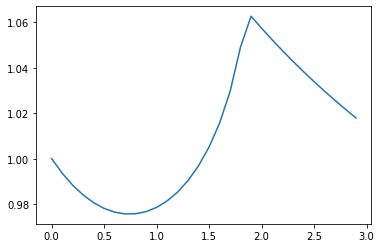

In [13]:
import matplotlib.pyplot as plt
plt.plot(Outcomes['varphi'], Outcomes['pe'])

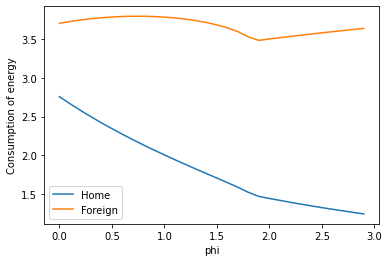

In [14]:
plt.plot(Outcomes['varphi'], Outcomes['Cec_prime'], label = "Home")
plt.plot(Outcomes['varphi'], Outcomes['Cecstar_prime'], label = "Foreign")
plt.xlabel("phi")
plt.ylabel("Consumption of energy")
plt.legend()
plt.savefig('phi_cec.pdf', format='PDF')

In [15]:
Outcomes['petb'] = Outcomes['pe'] + Outcomes['tb']

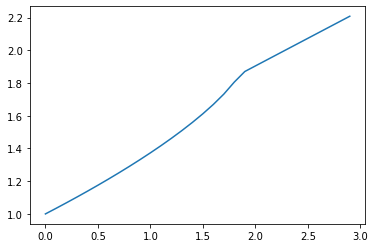

In [16]:
plt.plot(Outcomes['varphi'], Outcomes['petb'])

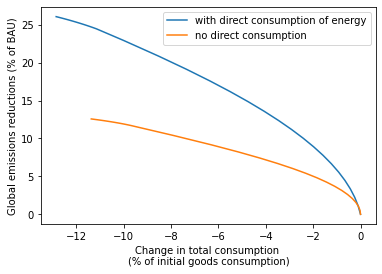

In [38]:
df = pd.read_csv('../../output/output_case3.csv')
df = df[(df['region_scenario'] == 1) & (df['tax_sce'] == 'Unilateral') & (df['varphi'] <= 3)]
Outcomes['Qeworld_chg']=-(Outcomes['Qeworld_prime']-32.2760)/32.2760*100
plt.plot(Outcomes['welfare_noexternality'], Outcomes['Qeworld_chg'], label = 'with direct consumption of energy')

df['Qeworld_chg']=-(df['Qeworld_prime']-32.2760)/32.2760*100
plt.plot(df['welfare_noexternality'], df['Qeworld_chg'], label = 'no direct consumption')

plt.xlabel('Change in total consumption \n(% of initial goods consumption)')
plt.ylabel('Global emissions reductions (% of BAU)')
plt.legend()

plt.savefig('wf_chg.pdf', format = 'PDF')

In [29]:
df

,regionbase,tax_sce,region_scenario,tb,prop,te,varphi,pe,jxbar_prime,jmbar_prime,...,chg_extraction,chg_production,chg_consumption,chg_Qeworld,pai_g,subsidy_ratio,welfare,welfare_noexternality,prop2,Qeworld_chg
